In [ ]:
import csv
import operator
import calendar
import matplotlib.pyplot as plt
from datetime import datetime
from pprint import pprint

**Possing Questions**

1. What are the proportions of each users category (female/male/young/adult…) in each region?
> This helps to make smart decisions in investing to provide certain types of bicycles, such as: if in region A most of your users are females then it is a clever choice to consider adding more women-specific-design bikes as in general women’s physique have different shapes than the average man physique
2. In each region, what are proportions of each user type (subscriber/customer…)?
> This can help conduct further studies to learn more about the user’s decision, to stay just a customer for example
3. In each region, what are the parts of the day in which a high usage rate is recorder?
> This helps to identify where and when should the company consider adding more bicycles to certain stations in order to target a larger group of users
4. How is the rate of the bike’s usage evolving throughout the years in each region?
> This gives a global overview of the business growth
5. How many time (duration) each user is spending on the bike per year?
> Result can be grouped per gender/region/time of the day (morning, night…) in order to spot trends which can influence the business growth, and with further studies, we can understand the reason behind behavior and take action to enhance the service

# **Data Preparation**

In [ ]:
def loc_id(filename):
  return filename.split("-")[0].split("/")[-1]

In [ ]:
""" This functions prints and returns the first data point (second row) from a csv file that includes a header row
    INPUT  : filename (strings): path of the data file
    OUTPUT : second row in the file                                                                                 """
def print_first_point(filename):
  city = loc_id(filename)
  print("\nCity: {}".format(city))  # print city name for reference
  with open(filename, "r") as f_in:
    trip_reader = csv.DictReader(f_in)
    first_trip = next(trip_reader)
    pprint(first_trip)
  
  return (city, first_trip) # ouput city name and first trip for later testing

In [ ]:
# list of files for each city
data_files = ["/content/drive/MyDrive/Colab Notebooks/NYC-CitiBike-2016.csv",
              "/content/drive/MyDrive/Colab Notebooks/Chicago-Divvy-2016.csv",
              "/content/drive/MyDrive/Colab Notebooks/Washington-CapitalBikeshare-2016.csv"]

# print the first trip from each file
# then store in dictionary
example_trips = {}
for i in data_files:
  location, first_journey = print_first_point(i)
  example_trips[location] = first_journey


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

**Generate new data files with five values of interest for each trip:**

- **Duration**: This has been given to us in seconds (New York, Chicago) and miliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of _minutes_
- **Month, Hour, Day of Week**: Ridership volume is likely to change based on the season, time of day, and wheter it is a weekday or weekend. Use the _start time_ to obtain these values. The New York data includes the seconds in their timestamps, while Washington and Chicago do not, thus the `datetime` package will be very useful here to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share systems will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: _Registered_ for users with annual, monthly, and other longer-term subscriptions, and _Casual_ for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses _Subscriber_ and _Customer_ for these groups, respectively. Regarding consistency, the data will convert into two main categories: _Subscriber_ and _Customer_.

In [ ]:
class TransformsData:
  def __init__(self, dataframe, city):
    self.dataframe = dataframe
    self.city = city
  
  # takes as input a dictionary containing info about a single trip (dataframe) 
  # and its origin city (city) and returns the trip duration in units of minutes 
  # Note: Washington is in terms of miliseconds while 
  #       Chicago and NYC are in term of seconds
  def convert_duration(self):
    if (self.city == "NYC") | (self.city == "Chicago"):
      duration = int(self.dataframe["tripduration"])/60      # converion from seconds to minutes
    elif (self.city == "Washington"):
      duration = int(self.dataframe["Duration (ms)"])/60000  # converion from miliseconds to minutes
    
    # return the value converted
    return duration
  
  # takes as input a dictionary containing info about a single trip (dataframe)
  # and its origin city (city) and returns the month, hour, and day of the week
  # in which the trip was made
  # Note: NYC includes seconds while Washington and Chicago are not
  def convert_time_of_trip(self):
    date_format = None
    attribute_key = None
    
    # select pattern's format from the dataset
    if (self.city == "NYC"):
      date_format = "%m/%d/%Y %H:%M:%S"
      attribute_key = "starttime"
    elif (self.city == "Chicago"):
      date_format = "%m/%d/%Y %H:%M"
      attribute_key = "starttime"
    elif (self.city == "Washington"):
      date_format = "%m/%d/%Y %H:%M"
      attribute_key = "Start date" 
  
    # convert the pattern of date
    month = datetime.strptime(self.dataframe[attribute_key], date_format).month
    hour = datetime.strptime(self.dataframe[attribute_key], date_format).hour
    day_of_week = datetime.strptime(self.dataframe[attribute_key], date_format).strftime("%A")

    return (month, hour, day_of_week)
  
  # takes as input a dictionary containing info about a single trip (dataframe)
  # and its origin city (city) and returns the type of system's user that 
  # made the trip 
  # Note: Washington has different category names compared others
  def convert_type_of_user(self):

    # select the data and convert the pattern of type of user
    if (self.city == "Washington"):
      if (self.dataframe["Member Type"] == "Registered"):
        user_type = "Subscriber"
      else:
        user_type = "Customer"
    elif (self.city == "NYC") | (self.city == "Chicago"):
      user_type = self.dataframe["usertype"]
  
    return user_type

In [ ]:
# inheritance class to assert data transformation from class TransformData
class AssertTrasformation(TransformsData):
  def __init__(self, source, key_1, key_2, key_3):
    super().__init__(None, None)  # initialize dataframe and city as null
    self.path = source
    self.key_1 = key_1
    self.key_2 = key_2
    self.key_3 = key_3
  
  def assert_duration(self):
    for i in self.key_1:
      self.dataframe = example_trips[loc_id(i)]   # initialize dataframe
      self.city = i                               # initialize city
      assert abs(self.convert_duration() - self.key_1[i]) < 0.001
    
    for i in self.path:
      self.dataframe = example_trips[loc_id(i)]   # initialize dataframe
      self.city = loc_id(i)                       # initialize city
      print("Duration in minute results for {} {},".format(loc_id(i), self.convert_duration()))
      print("- the correct value for {} is {}".format(loc_id(i), self.key_1[loc_id(i)]))
    # additional space
    print("")
  
  def assert_day_of_trip(self):
    for i in self.key_2:
      self.dataframe = example_trips[loc_id(i)]   # initialize dataframe
      self.city = i                               # initialize city
      assert self.convert_time_of_trip() == self.key_2[i]
    
    for i in self.path:
      self.dataframe = example_trips[loc_id(i)]   # initialize dataframe
      self.city = loc_id(i)                       # initialize city
      print("Time format results for {} {},".format(loc_id(i), self.convert_time_of_trip()))
      print("- the correct value for {} is {}".format(loc_id(i),self.key_2[loc_id(i)]))
    # additional space
    print("")
  
  def assert_type_of_user(self):
    for i in self.key_3:
      self.dataframe = example_trips[loc_id(i)]   # initialize dataframe
      self.city = i                               # initialize city
      assert self.convert_type_of_user() == self.key_3[i]
    
    for i in self.path:
      self.dataframe = example_trips[loc_id(i)]   # initialize dataframe
      self.city = loc_id(i)                       # initialize city
      print("User type results for {} {},".format(loc_id(i), self.convert_type_of_user()))
      print("- the correct value for {} is {}".format(loc_id(i),self.key_3[loc_id(i)]))
    # additional space
    print("")
  
  def assert_transformation(self):
    print("1. Assert for convertion duration:")
    self.assert_duration()
    print("2. Assert for convertion day of trip:")
    self.assert_day_of_trip()
    print("3. Assert for convertion type of user:")
    self.assert_type_of_user()

In [ ]:
# testing the code
tests_1 = {"NYC": 13.9833,
           "Chicago": 15.4333,
           "Washington": 7.1231}

tests_2 = {"NYC": (1, 0, "Friday"),
           "Chicago": (3, 23, "Thursday"),
           "Washington": (3, 22, "Thursday")}

tests_3 = {"NYC": "Customer",
           "Chicago": "Subscriber",
           "Washington": "Subscriber"}

AssertTrasformation(data_files, tests_1, tests_2, tests_3).assert_transformation()

1. Assert for convertion duration:
Duration in minute results for NYC 13.983333333333333,
- the correct value for NYC is 13.9833
Duration in minute results for Chicago 15.433333333333334,
- the correct value for Chicago is 15.4333
Duration in minute results for Washington 7.123116666666666,
- the correct value for Washington is 7.1231

2. Assert for convertion day of trip:
Time format results for NYC (1, 0, 'Friday'),
- the correct value for NYC is (1, 0, 'Friday')
Time format results for Chicago (3, 23, 'Thursday'),
- the correct value for Chicago is (3, 23, 'Thursday')
Time format results for Washington (3, 22, 'Thursday'),
- the correct value for Washington is (3, 22, 'Thursday')

3. Assert for convertion type of user:
User type results for NYC Customer,
- the correct value for NYC is Customer
User type results for Chicago Subscriber,
- the correct value for Chicago is Subscriber
User type results for Washington Subscriber,
- the correct value for Washington is Subscriber



In [ ]:
""" This function takes full data from the specific input file
    and writes the condensed data to a specific output file.
    The city argument determines how the input file will be parsed. """
def condense_data(in_file, out_file, city):
  with open(out_file, "w") as f_out, open(in_file, "r") as f_in:
    out_colnames = ["duration", "month", "hour", "day_of_week", "user_type"]
    trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
    trip_writer.writeheader()   # write header file
    trip_reader = list(csv.DictReader(f_in))

    for i in trip_reader:
      new_point = {}  # temporary collect information for a row
      c = TransformsData(i, city) # initialize
      new_point[out_colnames[0]] = c.convert_duration()
      new_point[out_colnames[1]], new_point[out_colnames[2]], new_point[out_colnames[3]] = c.convert_time_of_trip()
      new_point[out_colnames[4]] = c.convert_type_of_user()

      trip_writer.writerow(new_point)   # write rows file

In [ ]:
cities_info = {"NYC":{"in_file": "/content/drive/MyDrive/Colab Notebooks/NYC-CitiBike-2016.csv",
                             "out_file": "/content/drive/MyDrive/Colab Notebooks/NYC-Summary-2016.csv"},
               "Chicago":{"in_file": "/content/drive/MyDrive/Colab Notebooks/Chicago-Divvy-2016.csv",
                          "out_file": "/content/drive/MyDrive/Colab Notebooks/Chicago-Summary-2016.csv"},
               "Washington":{"in_file": "/content/drive/MyDrive/Colab Notebooks/Washington-CapitalBikeshare-2016.csv",
                      "out_file": "/content/drive/MyDrive/Colab Notebooks/Washington-Summary-2016.csv"}}

# i --> city
# j --> filenames
for i, j in cities_info.items():
  condense_data(j["in_file"], j["out_file"], i)
  print_first_point(j["out_file"])


City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])


# **Exploratory Data Analysis**

In [ ]:
input_files = ["/content/drive/MyDrive/Colab Notebooks/NYC-Summary-2016.csv",
              "/content/drive/MyDrive/Colab Notebooks/Chicago-Summary-2016.csv",
              "/content/drive/MyDrive/Colab Notebooks/Washington-Summary-2016.csv"]

In [ ]:
class EDA:
  def __init__(self, filename):
    self.filename = filename
  
  # this method reads in a file with trip data and reports 
  # the number of trips made by subscribers, customrs, and total overall
  def number_of_trips(self):
    with open(self.filename, "r") as f_in:
      reader = csv.DictReader(f_in)

      # compute rides by type
      number_of_subscribers = 0
      number_of_customers = 0
      for i in reader:
        if (i["user_type"] == "Subscriber"):
          number_of_subscribers += 1
        elif (i["user_type"] == "Customer"):
          number_of_customers += 1
      
      total_rider = number_of_subscribers + number_of_customers
      return (number_of_subscribers, number_of_customers, total_rider)

  # this method takes as an input a path of CSV file (filename) for a given city and returns: 
  # (1) the average trip length for each city, and (2) proportion of rides made in each city 
  # are longer than 30 minutes
  def average_and_charged_proportion(self):
    list_of_trip_duration = []
    charged_trips = 0
    with open(self.filename, "r") as f:
      reader = csv.DictReader(f)
      for i in reader:
        trip_duration = float(i["duration"])
        list_of_trip_duration.append(trip_duration)
        if (trip_duration > 30):
          charged_trips += 1
  
    average_trip_length = sum(list_of_trip_duration)/len(list_of_trip_duration)
    charged_rides_proportion = (charged_trips/len(list_of_trip_duration))*100
    return average_trip_length, charged_rides_proportion
  
  # this method takes as an input a path of CSV file (input_filename) and then
  # returns a dict that have for each user type the average trip duration
  def average_rides_users(self):
    number_of_subscriber = 0
    number_of_customer = 0
    result = {"Subscriber":0, "Customer":0}
    with open(self.filename, "r") as f:
      reader = csv.DictReader(f)
      for i in reader:
        if (i["user_type"] == "Subscriber"):
          number_of_subscriber += 1
          result["Subscriber"] += float(i["duration"])
        elif (i["user_type"] == "Customer"):
          number_of_customer += 1
          result["Customer"] += float(i["duration"])
  
    result["Subscriber"] = result["Subscriber"]/number_of_subscriber
    result["Customer"] = result["Customer"]/number_of_subscriber
    return result
  
  # this method returns the bike trips durations 
  # for a certain user type in a certain city
  def trip_times_by_user_type(self, user_type):
    times = []
    with open(self.filename, "r") as f:
      reader = csv.DictReader(f)
      for i in reader:
        if (i["user_type"] == user_type):
          times.append(round(float(i["duration"]), 2))
  
    return times
  
  # this method takes as an input a ridership informations file of a certain city
  # then returns:
  # (1) month_stats = Dict{month : number_of_trips}
  # (2) mode_month = String ->  the month that has the highest ridership
  # (3) mode_month_cust = String -> the month that has the highest ridership for customers
  # (4) mode_month_subscri = String -> the month that has the highest ridership for subscribers
  # (5) ratio_by_type = Dict{month : ratio} -> ratio of customers and subscribers for each month
  def ridership_by_month(self):
    month_stats = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}
    cust_trips = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}
    subscri_trips = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}

    with open(self.filename, "r") as f:
      reader = csv.DictReader(f)
      for i in reader:
        month_stats[int(i["month"])] += 1
        if (i["user_type"] == "Customer"):
          cust_trips[int(i["month"])] += 1
        elif (i["user_type"] == "Subscriber"):
          subscri_trips[int(i["month"])] += 1

    ratio_by_type = {i: round((cust_trips[i]/subscri_trips[i]), 2) for i in cust_trips}
    mode_month = calendar.month_name[max(month_stats.items(), key=operator.itemgetter(1))[0]]
    mode_month_cust = calendar.month_name[max(cust_trips.items(), key=operator.itemgetter(1))[0]]
    mode_month_subscri =  calendar.month_name[max(subscri_trips.items(), key=operator.itemgetter(1))[0]]
    return {"mode_month":mode_month, "mode_month_cust":mode_month_cust, 
            "mode_month_subscri":mode_month_subscri,
            "month_stats":month_stats, "month_ratio_by_type":ratio_by_type,
            "month_cust_trips":cust_trips, "month_subscri_trips":subscri_trips}

# Statistics

First, let's compute basic counts. The first some cell below contains a function that aim to used the csv file to iterate through a provide data, returning the number of trips made by subscribers and customers.

In [ ]:
class Statistic(EDA):   # inheritance from class EDA to analyze all cities input
  def __init__(self, list_of_data_files):
    super().__init__(None)                        # initialize filename as null
    self.list_of_data_files = list_of_data_files
  
  # method to runs number_of_trips for all cities input
  def dominations(self):
    trips_count = {}
    subscribers_proportion = {}
    customers_proportion = {}
    for i in self.list_of_data_files:
      self.filename = i     # initialize input filename for class EDA
      city = i.split("-")[0].split("/")[-1]
      trips_count[city] = self.number_of_trips()[2]
      subscribers_proportion[city] = self.number_of_trips()[0]/self.number_of_trips()[2]
      customers_proportion[city] = self.number_of_trips()[1]/self.number_of_trips()[2]

    alpha = max(trips_count.items(), key=operator.itemgetter(1))[0]
    bravo = max(trips_count.items(), key=operator.itemgetter(1))[1]
    charlie = max(subscribers_proportion.items(), key=operator.itemgetter(1))[0]
    delta = max(subscribers_proportion.items(), key=operator.itemgetter(1))[1]
    echo = max(customers_proportion.items(), key=operator.itemgetter(1))[0]
    foxtrot = max(customers_proportion.items(), key=operator.itemgetter(1))[1]

    return (alpha, bravo, charlie, delta, echo, foxtrot)
  
  # method to runs average_and_charged_proportion for all cities input
  def investigation_charged_trips_each_city(self):
    result = []
    for i in self.list_of_data_files:
      self.filename = i     # initialize input filename for class EDA
      city_info = {}
      city = i.split("-")[0].split("/")[-1]
      city_info["city_name"] = city
      city_info["avg_trip_duration"], city_info["charged_rides_proportion"] = self.average_and_charged_proportion()
      result.append(city_info)
    # return as turple
    return result
  
  # method to runs average_rides_users for all cities input
  def identifies_usage(self):
    result = []
    max_rides_user = []
    for i in self.list_of_data_files:
      self.filename = i     # initialize input filename for class EDA
      tmp1 = self.average_rides_users()
      tmp2 = max(tmp1)
      result.append(tmp1)
      max_rides_user.append(tmp2)
  
    return result, max_rides_user

**Question**: Which city has the highest number of trips? Which city has the highest proportion of trips made by subscribers? Which city has the highest proportion of trips made by short-term customers?

In [ ]:
x1, x2, x3, x4, x5, x6 = Statistic(input_files).dominations()

print("The city that has the highest number of trips is {} with a total of {} trips".format(x1, x2))
print("The city that has the highest proportion of trips made by subscribers is {} with a proportion of {:0.2f}".format(x3, x4))
print("The city that has the highest proportion of trips made by customers is {} with a proportion up to {:0.2f}".format(x5, x6))

The city that has the highest number of trips is NYC with a total of 276081 trips
The city that has the highest proportion of trips made by subscribers is NYC with a proportion of 0.89
The city that has the highest proportion of trips made by customers is Chicago with a proportion up to 0.24


**Question**: Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. 
What is the average trip length for each city? What proportion of rides made in each city are longer than 30 minutes?

In [ ]:
list_of_information = Statistic(input_files).investigation_charged_trips_each_city()

for i in list_of_information:
  print("- city: {}".format(i["city_name"]))
  print("- average trip duration: {:0.2f}".format(i["avg_trip_duration"]))
  print("- proportion of charged ride: {:0.2f}\n".format(i["charged_rides_proportion"]))

- city: NYC
- average trip duration: 15.81
- proportion of charged ride: 7.30

- city: Chicago
- average trip duration: 16.56
- proportion of charged ride: 8.33

- city: Washington
- average trip duration: 18.93
- proportion of charged ride: 10.84



In [ ]:
identifies, user = Statistic(input_files).identifies_usage()

# extract the information
for i in range(0, len(input_files)):
  print("For {} The type of users that has the longer rides on average is {} with an average of {:0.2f} minutes".format(loc_id(input_files[i]), user[i], identifies[i][user[i]]))

For NYC The type of users that has the longer rides on average is Subscriber with an average of 13.68 minutes
For Chicago The type of users that has the longer rides on average is Subscriber with an average of 12.07 minutes
For Washington The type of users that has the longer rides on average is Subscriber with an average of 12.53 minutes


# Visualization

In [ ]:
class Visualization(EDA):   # inheritance from class EDA to visualize all cities input
  def __init__(self, list_of_data_files):
    super().__init__(None)                        # initialize filename as null
    self.list_of_data_files = list_of_data_files
  
  # method to collect all of the trip times as a list
  # and then use the list to generate a histogram of trip times
  def plot_trip_times(self, order):
    filename = self.list_of_data_files[order]
    city = loc_id(self.list_of_data_files[order])
    times = []
    with open(filename, "r") as f:
      reader = csv.DictReader(f)
      for i in reader:
        times.append(round(float(i["duration"]), 2))
  
    plt.hist(times)
    plt.title("Histogram of "+str(city)+"'s bike trips duration")
    plt.xlabel("Duration in minutes")
    plt.ylabel("Frequency")
    plt.show()
  
  # method to runs plot_trip_times for all cities input
  def histogram_of_trip_durations(self):
    for i in range(0, len(self.list_of_data_files)):
      print("\nHistogram for {}".format(loc_id(self.list_of_data_files[i])))
      self.plot_trip_times(i)
  
  # method to plot the distribution of trip times for the Subscribers in all selected city 
  # add limit to the plots so that only trips of duration less than 75 minute are plotted
  def plot_trip_times_by_user_type(self):
    minutes = 75
    wide_intervals = 5
    bins = [wide_intervals * i for i in range(int(minutes/wide_intervals))]
    for i in self.list_of_data_files:
      self.filename = i
      city = loc_id(i)
      subscribers = self.trip_times_by_user_type("Subscriber")
      customers = self.trip_times_by_user_type("Customer")

      print("----------------------------------------------------------")
      print("Distribution of {}'s {} trip durations".format(city, "subscriber"))
      plt.hist(subscribers, bins, range=(0, minutes))
      plt.xticks(range(0, 80, 5))   # used to set locations labels in the x-axis
      plt.title("Distribution of "+str(city)+"'s Subscriber trips duration")
      plt.xlabel("Duration in minutes")
      plt.ylabel("Frequency")
      plt.show()

      print("\nDistribution of {}'s {} trip durations".format(city,  "customer"))
      plt.hist(customers, bins, range=(0, minutes))
      plt.xticks(range(0, 80, 5))   # used to set locations labels in the x-axis
      plt.title("Distribution of "+str(city)+"'s  Customer trips duration")
      plt.xlabel("Duration in minutes")
      plt.ylabel("Frequency")
      plt.show()

  # this method plotting the monthly ridership using input:
  # (1) monthly_stats(Dict) --> month_stats: contains the number of trips per month in a given city
  # (2) monthly_sub(Dict) --> month_subscri_trips: contains the number of trips by subscribers per month in a given city
  # (3) monthly_custs(Dict) --> month_cust_trips: contains the number of trips by customers per month in a given city
  # (4) ratio(Dict) --> month_ratio_by_type: contains the ratio between subscribers and customers trips per month 
  #     in a given city
  def plot_ridership_month(self):

    # collecting results
    results = {}
    for i in self.list_of_data_files:
      self.filename = i
      city = i.split("-")[0].split("/")[-1]
      results[city] = self.ridership_by_month()
    
    # visualize it
    for key, value in results.items():
      print("results for {}".format(key))
      print("- the month that has the highest ridership rate is: {}".format(value["mode_month"]))
      print("- the month that has the highest ridership rate in term of subscribers is: {}".format(value["mode_month_subscri"]))
      print("- the month that has the highest ridership rate in term of customers is: {}".format(value["mode_month_cust"]))
      
      print("visualization for {}'s distributions...".format(key))
      plt.bar(range(len(value["month_stats"])), value["month_stats"].values(), align="center")
      plt.title("monthly ridership report of {}".format(key))
      plt.xticks(range(len(value["month_stats"])), value["month_stats"].keys())
      plt.show()
      print("---------------------------")
      plt.bar(range(len(value["month_subscri_trips"])), value["month_subscri_trips"].values(), align="center")
      plt.title("monthly ridership by subscribers report of {}".format(key))
      plt.xticks(range(len(value["month_subscri_trips"])), value["month_subscri_trips"].keys())
      plt.show()
      print("---------------------------")
      plt.bar(range(len(value["month_cust_trips"])), value["month_cust_trips"].values(), align="center")
      plt.title("monthly ridership by customers report of {}".format(key))
      plt.xticks(range(len(value["month_cust_trips"])), value["month_cust_trips"].keys())
      plt.show()
      print("---------------------------")
      plt.bar(range(len(value["month_ratio_by_type"])), value["month_ratio_by_type"].values(), align="center")
      plt.title("monthly ratio of ridership by tipe report of {}".format(key))
      plt.xticks(range(len(value["month_ratio_by_type"])), value["month_ratio_by_type"].keys())
      plt.show()
      print("\n\n")


Histogram for NYC


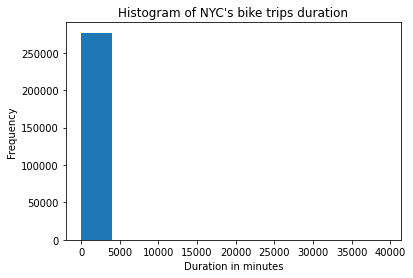


Histogram for Chicago


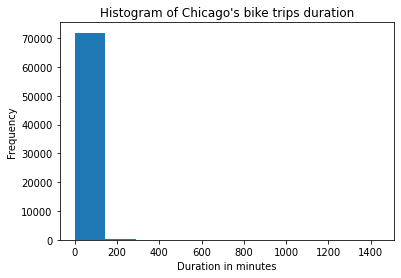


Histogram for Washington


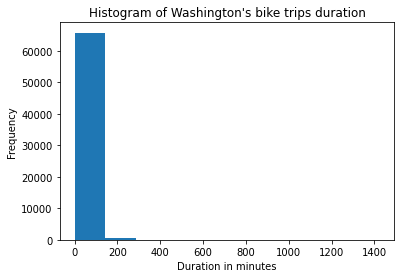

In [ ]:
Visualization(input_files).histogram_of_trip_durations()

Plot the distribution of trip times for the Subscribers in all selected city. Add limit to the plots so that only trips of duration less than 75 minute are plotted. Also, set the plots up so that bars are in five-minute wide intervals.
For each group, where is the peak of each distribution? How would you describe the shape of each distribution?

----------------------------------------------------------
Distribution of NYC's subscriber trip durations


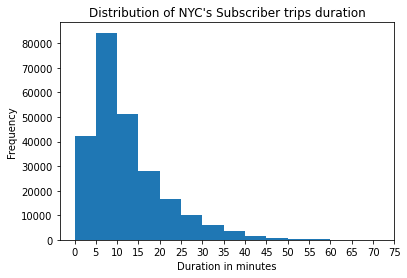


Distribution of NYC's customer trip durations


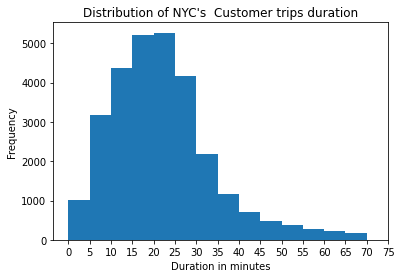

----------------------------------------------------------
Distribution of Chicago's subscriber trip durations


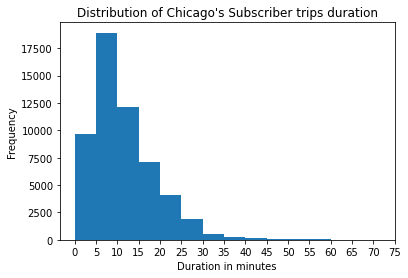


Distribution of Chicago's customer trip durations


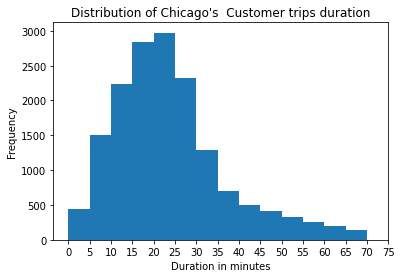

----------------------------------------------------------
Distribution of Washington's subscriber trip durations


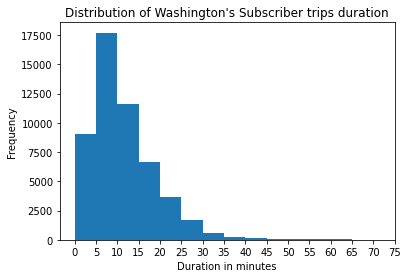


Distribution of Washington's customer trip durations


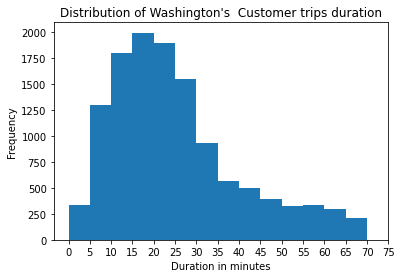

In [ ]:
Visualization(input_files).plot_trip_times_by_user_type()

- How does ridership differ by month or season in each city?
- Which month/season has the highest ridership in each city?
- How does the ratio of Subscriber trips to Customers trips change in each of the three cities?

results for NYC
- the month that has the highest ridership rate is: September
- the month that has the highest ridership rate in term of subscribers is: September
- the month that has the highest ridership rate in term of customers is: August
visualization for NYC's distributions...


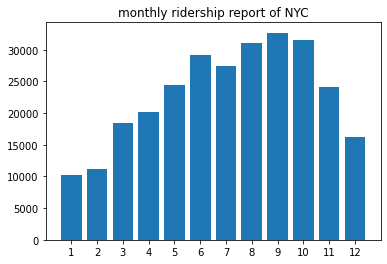

---------------------------


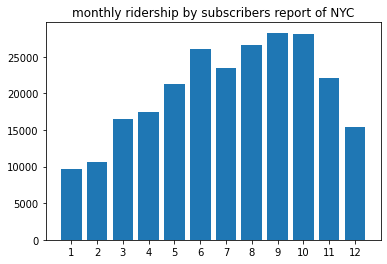

---------------------------


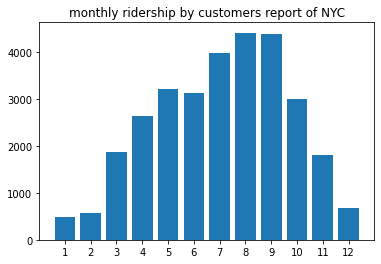

---------------------------


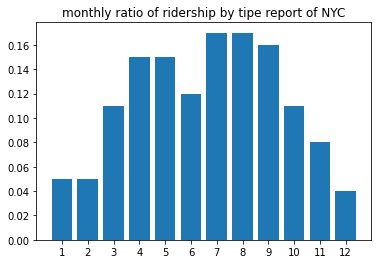




results for Chicago
- the month that has the highest ridership rate is: July
- the month that has the highest ridership rate in term of subscribers is: June
- the month that has the highest ridership rate in term of customers is: July
visualization for Chicago's distributions...


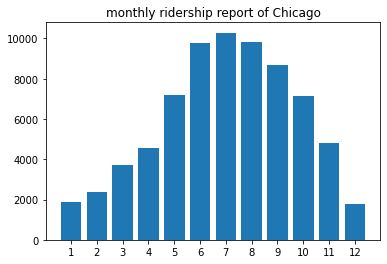

---------------------------


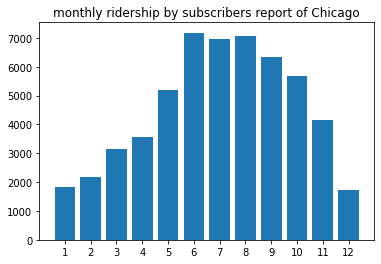

---------------------------


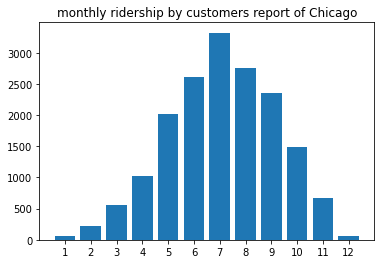

---------------------------


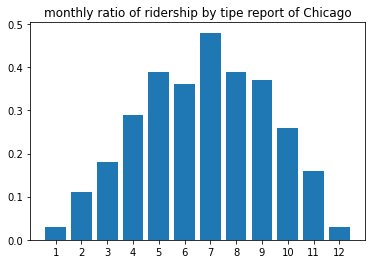




results for Washington
- the month that has the highest ridership rate is: July
- the month that has the highest ridership rate in term of subscribers is: June
- the month that has the highest ridership rate in term of customers is: July
visualization for Washington's distributions...


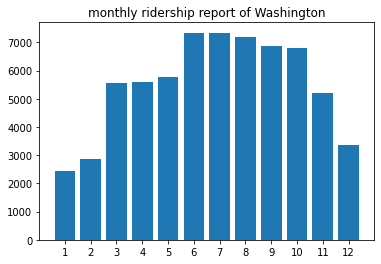

---------------------------


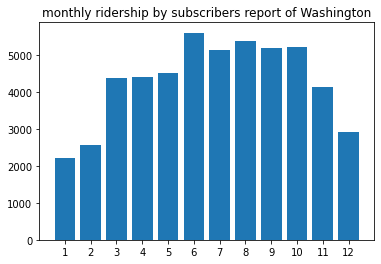

---------------------------


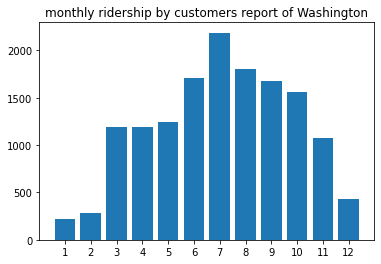

---------------------------


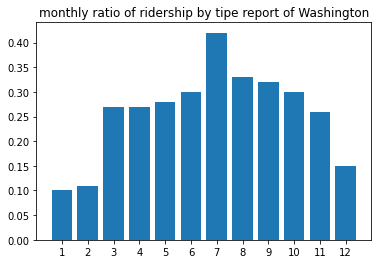

In [ ]:
Visualization(input_files).plot_ridership_month()

In [ ]:
from subprocess import call
call(["python", "-m", "nbconvert", "madaraku.ipynb"])

255